# Hopfield神经网络解决TSP问题
22210980051 李韵

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [32]:
# 第一步: 设置初始值
cities = np.array([[1, 5], [2, 4], [1, 1], [4, 7], [5, 6], [4, 3], [6, 5]])
N = len(cities)
A = N * N
D = N / 2
U0 = 0.0009
step = 0.0001
max_num_iter = 10000

In [33]:
# 第二步: 计算两城市间的距离dxy
def price_cn(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))

def get_distance(cities):
    N = len(cities)
    distance = np.zeros((N, N))
    for i, curr_point in enumerate(cities):
        line = []
        [line.append(price_cn(curr_point, other_point)) if i != j else line.append(0.0) for j, other_point in enumerate(cities)]
        distance[i] = line
    return distance

In [34]:
distance = get_distance(cities)

In [35]:
def calc_du(V, distance):
    a = np.sum(V, axis=0) - 1  # 按列相加
    b = np.sum(V, axis=1) - 1  # 按行相加
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c

In [36]:
def calc_U(U, du, step):
    return U + du * step

In [37]:
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))

In [118]:
# 第三步: 初始化输入电压Uxi和输出电压Vxi
U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)
V = calc_V(U, U0)

In [39]:
def calc_energy(V, distance):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e


In [40]:
def check_path(V):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV

In [41]:
def calc_distance(path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis

In [119]:
# 能量、距离、路线初始化
energies = np.array([0.0 for x in range(max_num_iter)])
best_distance = np.inf
best_route = []
H_path = []
best_iter = 0

In [120]:
# 迭代训练网络
for n in range(max_num_iter):
    # 第四步: 根据动力微分方程计算dUxi/dt
    du = calc_du(V, distance)
    # 第五步: 采用一阶欧拉法计算Uxi(t+1)
    U = calc_U(U, du, step)
    # 第六步: 使用sigmoid函数计算Vxi(t+1)
    V = calc_V(U, U0)
    # 第七步: 计算能量函数E
    energies[n] = calc_energy(V, distance)
    # 第八步: 检查路径的合法性
    route, newV = check_path(V)
    if len(np.unique(route)) == N:
        route.append(route[0])
        dis = calc_distance(route)
        if dis < best_distance:
            H_path = []
            best_distance = dis
            best_route = route
            [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
            best_iter = n
            print('第{}次迭代得到的次优解距离为：{}，能量为：{}，路径为：'.format(best_iter, round(best_distance,4), round(energies[best_iter],4)))
            [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)] 

第76次迭代得到的次优解距离为：22.9016，能量为：49.5902，路径为：
d,e,c,f,b,a,g,d
第1175次迭代得到的次优解距离为：17.4444，能量为：125.8845，路径为：
f,c,b,a,d,e,g,f
第2177次迭代得到的次优解距离为：17.4444，能量为：35.9533，路径为：
c,b,a,d,e,g,f,c


In [144]:
def draw_H_and_E(cities, H_path, energies):
    fig = plt.figure(figsize=(12,6))
    # 绘制哈密顿回路
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Optimal solution')
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(cities[from_], 0.1, color='blue')
        p2 = plt.Circle(cities[to_], 0.1, color='blue')
        ax1.add_patch(p1)
        ax1.add_patch(p2)
        ax1.plot((cities[from_][0], cities[to_][0]), (cities[from_][1], cities[to_][1]), color='green')
        ax1.annotate(text=chr(97 + to_), xy=cities[to_], xytext=(-6, 12), textcoords='offset points', fontsize=20)
    ax1.axis('equal')
    ax1.grid()
    # 绘制能量趋势图
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Energy')
    ax2.plot(np.arange(0, len(energies), 1), energies, color='steelblue')
    plt.show()

最优解由第2177次迭代得到，距离为：17.4444，能量为：35.9533，路径为：
c,b,a,d,e,g,f,c


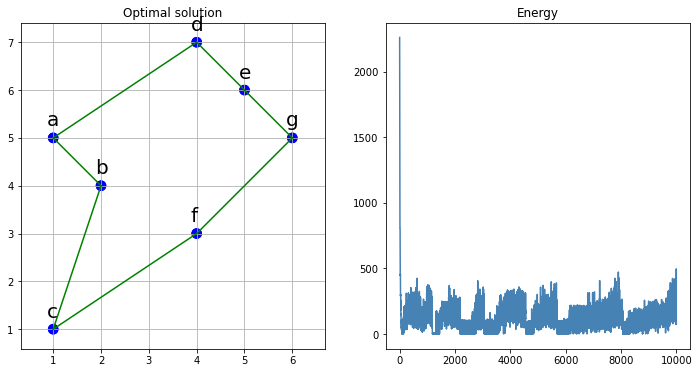

In [145]:
if len(H_path) > 0:
    print('最优解由第{}次迭代得到，距离为：{}，能量为：{}，路径为：'.format(best_iter, round(best_distance,4), round(energies[best_iter],4)))
    [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)] 
    draw_H_and_E(cities, H_path, energies)
else:
    print('没有找到最优解') 